In [15]:
import pandas as pd 

df = pd.read_csv('../../../data/Module3/IMDB-Dataset.csv')
print("Number duplicates: ", df.duplicated().sum())
df = df.drop_duplicates()


Number duplicates:  418


In [16]:
import re
import string 
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

stop = set(stopwords.words('english'))

def expand_contractions(text):
    return contractions.fix(text)

def preprocess_text(text):
    wl = WordNetLemmatizer()
    soup = BeautifulSoup(text, 'html.parser') #removing html tags
    text = soup.get_text()
    text = expand_contractions(text) #expanding chatwords and contracts clearing contractions
    emoji_clean = re.compile("["
                             u"\U0001F600-\U0001F64F"  # emoticons
                             u"\U0001F300-\U0001F5FF"  # symbols & pictographs  
                             u"\U0001F680-\U0001F6FF"  # transport & map symbols
                             u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                             u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'', text) #removing emojis
    text = re.sub(r'\.(?=\S)', '. ', text) #removing full stops, and adding space after full stops
    text = re.sub(r'http\S+', '', text) #removing urls
    text = "".join([
        word.lower() for word in text if word not in string.punctuation
    ]) #removing punctuations
    text = " ".join([
        wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()
    ]) #lemmatizing 
    return text

df['review'] = df['review'].apply(preprocess_text)






[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lapquang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/lapquang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/tmp/ipykernel_136002/1356158331.py:18: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser') #removing html tags


In [17]:
#the dictionary leangth after preprocessing
print("The dictionary length after preprocessing: ", len(set(" ".join(df['review']).split())))

The dictionary length after preprocessing:  143180


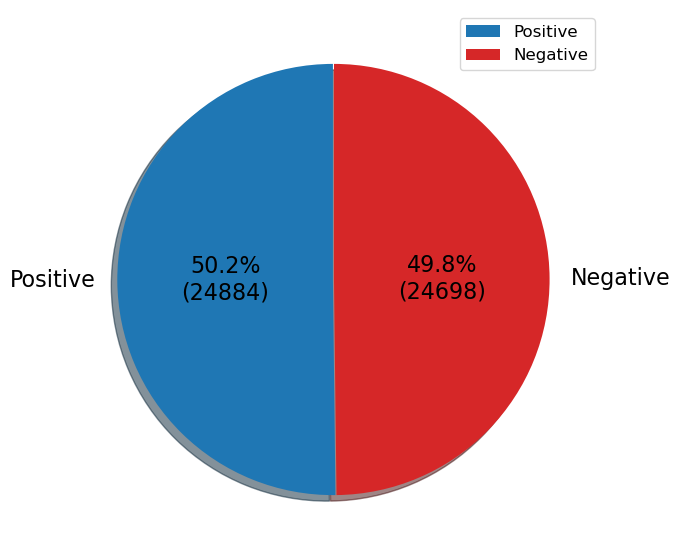

In [6]:
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]

labels = [r'Positive', r'Negative']

pie, ax = plt.subplots(figsize=[11,7])
plt.pie(data, autopct=lambda pct: func(pct, data),
        explode = [0.0025]*2, pctdistance=0.5, labels=labels, colors=[sns.color_palette()[0],'tab:red'],
          startangle=90, shadow=True, textprops={'fontsize': 16})

plt.legend(labels, loc = "best", prop={'size': 12})
pie.savefig("./IMDB-Dataset.png")
plt.show()

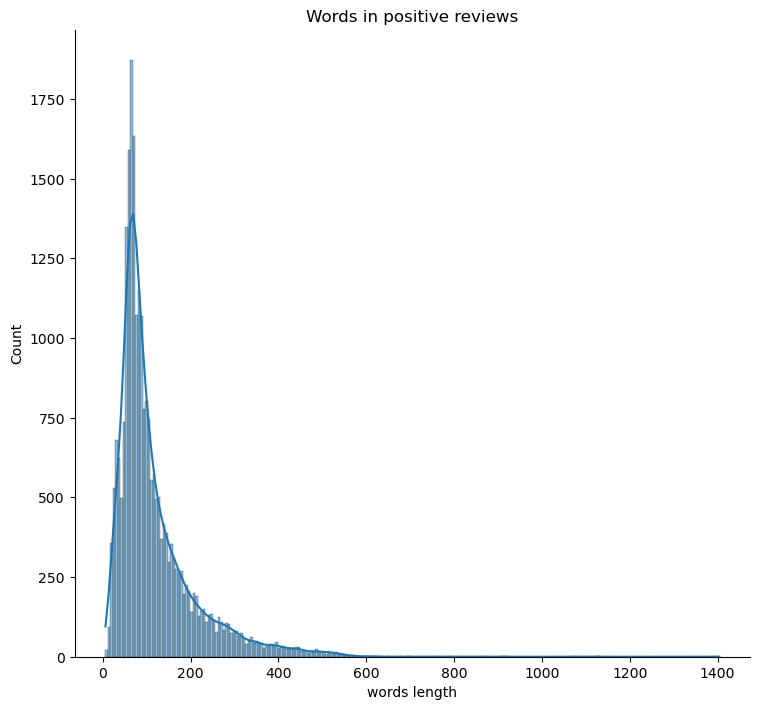

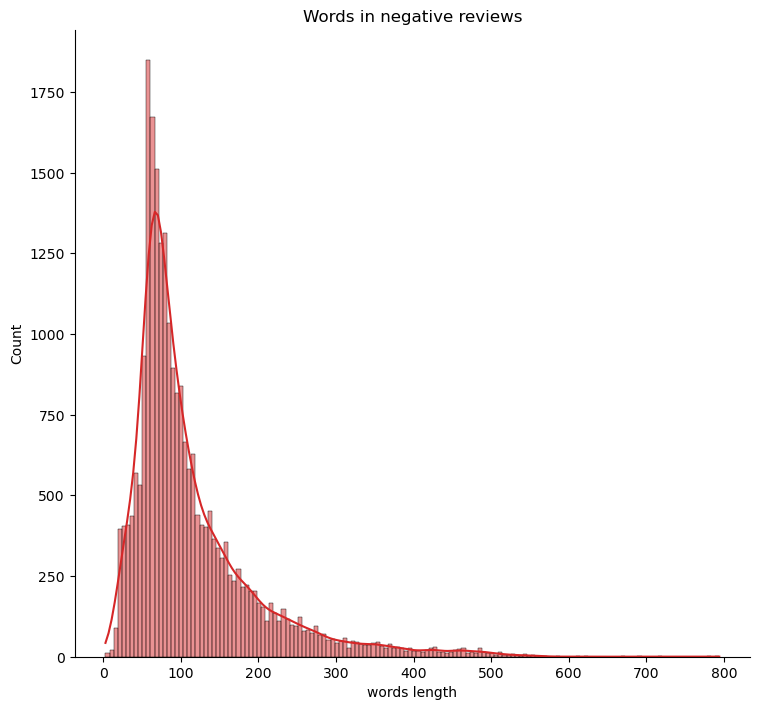

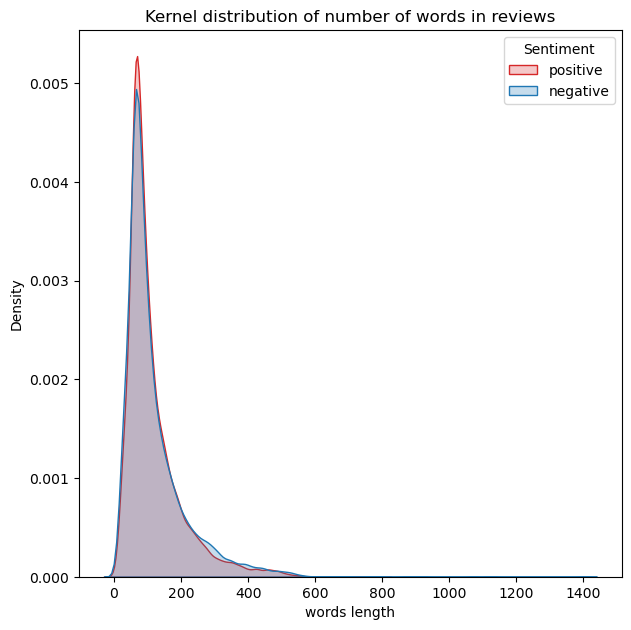

In [8]:
#plot the length for each sample in each sentiment
words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words length'] = words_len 

hist_positve = sns.displot(
    data = df_temp[df_temp['sentiment'] == 'positive'],
    x = "words length", hue="sentiment", kde = True, height = 7, aspect = 1.1,
    legend = False
).set(title = 'Words in positive reviews')
plt.show(hist_positve)

hist_negatve = sns.displot(
    data = df_temp[df_temp['sentiment'] == 'negative'],
    x = "words length", hue="sentiment", kde = True, height = 7, aspect = 1.1,
    legend = False, palette=['tab:red']
).set(title = 'Words in negative reviews')

plt.show(hist_negatve)

plt.figure(figsize=(7,7.1))
kernel_distribution_number_words_plot = sns.kdeplot(
    data = df_temp, x = "words length", hue = "sentiment", 
    fill = True, palette=[sns.color_palette()[0],'tab:red']
).set(title = 'Kernel distribution of number of words in reviews')
plt.legend(title='Sentiment', labels=['positive','negative'])
plt.show(kernel_distribution_number_words_plot)


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 

label_encoder = LabelEncoder()
X_data = df['review']
y_data = label_encoder.fit_transform(df['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

#---TF-IDF Vectorizer---
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train, y_train)

X_train_encoded = tfidf_vectorizer.transform(X_train)
X_test_encoded = tfidf_vectorizer.transform(X_test)

dt = DecisionTreeClassifier(
    criterion='entropy', random_state=42
)
dt.fit(X_train_encoded, y_train)
y_pred = dt.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy}")

Decision Tree Accuracy: 0.7180598971463145


In [18]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_encoded, y_train)
y_pred = rf.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy}")

Random Forest Accuracy: 0.8420893415347384


In [20]:
sentences = ["The movie was great, I hated it"]
sentences = pd.Series(sentences)
sentences = sentences.apply(preprocess_text)
sentences_encoded = tfidf_vectorizer.transform(sentences)
prediction = rf.predict(sentences_encoded)
prediction = label_encoder.inverse_transform(prediction)
print(f"Prediction: {prediction}")

Prediction: ['positive']
